In [2]:
dataverse_path='/Users/jessicasun/Desktop/research files/cones dataverse/data'

Plot data for appendix phase diagram

In [8]:
# %%capture

import sys
import numpy as np
import pandas as pd
import os
import trackpy as tp
import networkx as nx
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import colors
from matplotlib.colors import ListedColormap
from matplotlib import cm
from skimage import io, exposure
from skimage.filters import threshold_otsu, threshold_multiotsu, try_all_threshold, threshold_local
from skimage.morphology import skeletonize, convex_hull_image
from skimage.measure import label, regionprops_table
from skimage.color import rgb2gray, gray2rgb
from scipy.ndimage import binary_opening, binary_closing, binary_erosion, binary_dilation, rotate, gaussian_filter
from scipy import stats
from scipy.spatial.distance import cdist
from scipy.stats import circmean
from scipy.interpolate import griddata

In [9]:
#all slices in this folder are between 3.1-3.7hrs after sample prepared
#f = fluid phase. c = crystal + fluid coexistence. unlikely that we'll get pure crystal, and didnt observe that phase in my dataset.
dir_path=dataverse_path+'/all grains/figs/appendix/appendix phase diagram/selected data/slices'

data_df_list=[]
filename_list=os.listdir(dir_path)
for filename in filename_list:
    if filename.endswith('.tif'):        
        sampleID,conc_prepared,timerange=filename.split('_')
        time_start,time_end,sliceID,phase=timerange.split('-')
        phase=phase.split('.')[0]
        pathname=dir_path+'/'+filename
        data_df=pd.DataFrame([{'filename':filename,'pathname':pathname,'sampleID':sampleID,'conc_prepared':float(conc_prepared),'time_start':time_start,'time_end':time_end,'sliceID':sliceID,'phase':phase}])
        data_df_list+=[data_df]
data_df=pd.concat(data_df_list)
data_df['conc_final']=(data_df['conc_prepared']/4) #concentration in wt%, after mixing 2ul of particle solution with 2ul of 2mM NaCl and 4ul of 0.4mgml NaCMC250K
data_df['vol_frac']=data_df['conc_final']/100 #since polystyrene and water have approx same density, wt% is about same value as vol frac
data_df['area_frac']=-1.0
data_df=data_df.reset_index(drop=True)

In [10]:
data_df

,filename,pathname,sampleID,conc_prepared,time_start,time_end,sliceID,phase,conc_final,vol_frac,area_frac
0,B5_0.03125_1415.lif - 1750-1-c.tif,/Users/jessicasun/Desktop/research files/cones...,B5,0.03125,1415.lif,1750,1,c,0.007812,0.000078,-1.0
1,C6_0.60_1822.lif - 2155-2-c.tif,/Users/jessicasun/Desktop/research files/cones...,C6,0.60000,1822.lif,2155,2,c,0.150000,0.001500,-1.0
2,C8_0.80_1827.lif - 2158-3-c.tif,/Users/jessicasun/Desktop/research files/cones...,C8,0.80000,1827.lif,2158,3,c,0.200000,0.002000,-1.0
3,A6_0.30_1204.lif - 1517-3-c.tif,/Users/jessicasun/Desktop/research files/cones...,A6,0.30000,1204.lif,1517,3,c,0.075000,0.000750,-1.0
4,A4_0.20_1158.lif - 1513-2-c.tif,/Users/jessicasun/Desktop/research files/cones...,A4,0.20000,1158.lif,1513,2,c,0.050000,0.000500,-1.0
...,...,...,...,...,...,...,...,...,...,...,...
104,A5_0.25_1201.lif - 1515-1-c.tif,/Users/jessicasun/Desktop/research files/cones...,A5,0.25000,1201.lif,1515,1,c,0.062500,0.000625,-1.0
105,B6_0.03750_1418.lif - 1751-2-c.tif,/Users/jessicasun/Desktop/research files/cones...,B6,0.03750,1418.lif,1751,2,c,0.009375,0.000094,-1.0
106,A3_0.15_1155.lif - 1512-5-c.tif,/Users/jessicasun/Desktop/research files/cones...,A3,0.15000,1155.lif,1512,5,c,0.037500,0.000375,-1.0
107,A2_0.10_1153.lif - 1511-4-c.tif,/Users/jessicasun/Desktop/research files/cones...,A2,0.10000,1153.lif,1511,4,c,0.025000,0.000250,-1.0


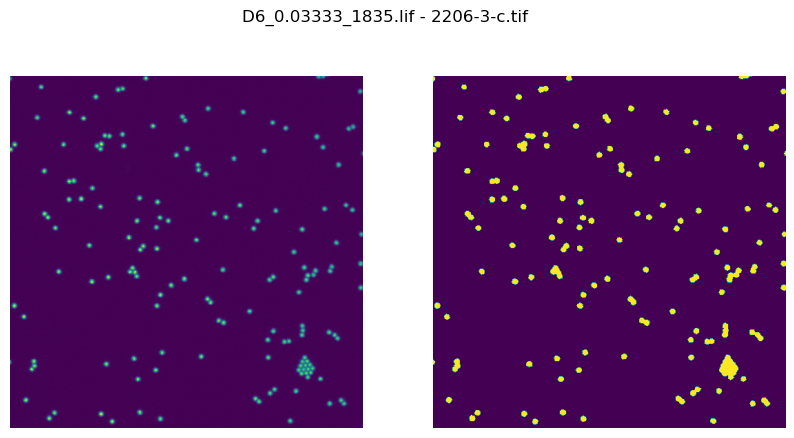

In [11]:
for file_idx in range(len(data_df)):
    im=np.array(plt.imread(data_df['pathname'][file_idx]))
    im=im[:,:,0] #convert RGBA to single intensity value image
    im_binary=(im>20)*1
    data_df.at[file_idx,'area_frac']=np.sum(im_binary)/np.sum(im_binary>=0)

fig=plt.figure(figsize=(10,5))
fig.suptitle(data_df['filename'][file_idx])
ax=fig.add_subplot(121)
ax.axis('off')
ax.imshow(im)

ax=fig.add_subplot(122)
ax.axis('off')
ax.imshow(im_binary)

(0.0, 1.0)

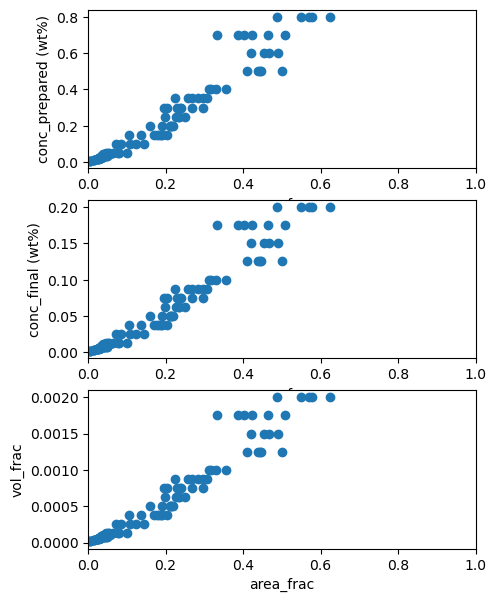

In [12]:
fig,axs=plt.subplots(3,1)
fig.set_size_inches(5,7)
filtered_df=data_df

ax=axs[0]
filtered_df=data_df
ax.scatter(filtered_df['area_frac'],filtered_df['conc_prepared'])
ax.set_xlabel('area_frac')
ax.set_ylabel('conc_prepared (wt%)')
ax.set_xlim(0,1)

ax=axs[1]
filtered_df=data_df
ax.scatter(filtered_df['area_frac'],filtered_df['conc_final'])
ax.set_xlabel('area_frac')
ax.set_ylabel('conc_final (wt%)')
ax.set_xlim(0,1)

ax=axs[2]
ax.scatter(filtered_df['area_frac'],filtered_df['vol_frac'])
ax.set_xlabel('area_frac')
ax.set_ylabel('vol_frac')
ax.set_xlim(0,1)

(0.0, 0.00015)

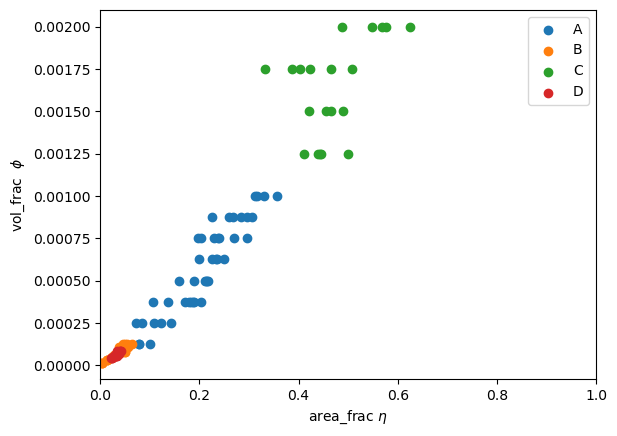

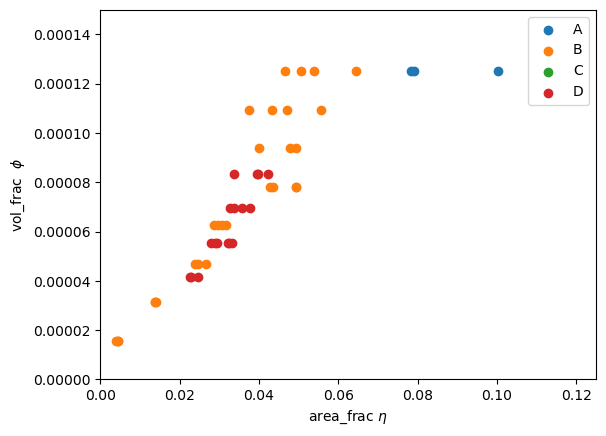

In [129]:
fig,ax=plt.subplots(1)
filtered_df=data_df[data_df['sampleID'].str.contains('A')]
ax.scatter(filtered_df['area_frac'],filtered_df['vol_frac'],label='A')

filtered_df=data_df[data_df['sampleID'].str.contains('B')]
ax.scatter(filtered_df['area_frac'],filtered_df['vol_frac'],label='B')

filtered_df=data_df[data_df['sampleID'].str.contains('C')]
ax.scatter(filtered_df['area_frac'],filtered_df['vol_frac'],label='C')

filtered_df=data_df[data_df['sampleID'].str.contains('D')]
ax.scatter(filtered_df['area_frac'],filtered_df['vol_frac'],label='D')

ax.legend()
ax.set_ylabel('vol_frac  '+r'$\phi$')
ax.set_xlabel('area_frac '+r'$\eta$')
ax.set_xlim(0,1)


fig,ax=plt.subplots(1)
filtered_df=data_df[data_df['sampleID'].str.contains('A')]
ax.scatter(filtered_df['area_frac'],filtered_df['vol_frac'],label='A')
filtered_df=data_df[data_df['sampleID'].str.contains('B')]
ax.scatter(filtered_df['area_frac'],filtered_df['vol_frac'],label='B')
filtered_df=data_df[data_df['sampleID'].str.contains('C')]
ax.scatter(filtered_df['area_frac'],filtered_df['vol_frac'],label='C')
filtered_df=data_df[data_df['sampleID'].str.contains('D')]
ax.scatter(filtered_df['area_frac'],filtered_df['vol_frac'],label='D')
ax.legend()
ax.set_ylabel('vol_frac  '+r'$\phi$')
ax.set_xlabel('area_frac '+r'$\eta$')
ax.set_xlim(0,0.125)
ax.set_ylim(0,0.00015)

(0.0, 0.00015)

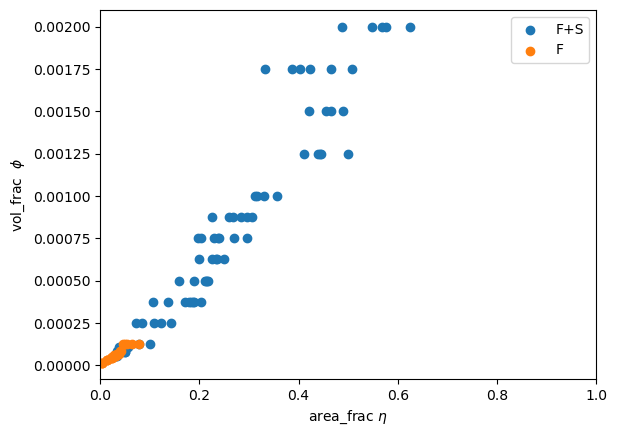

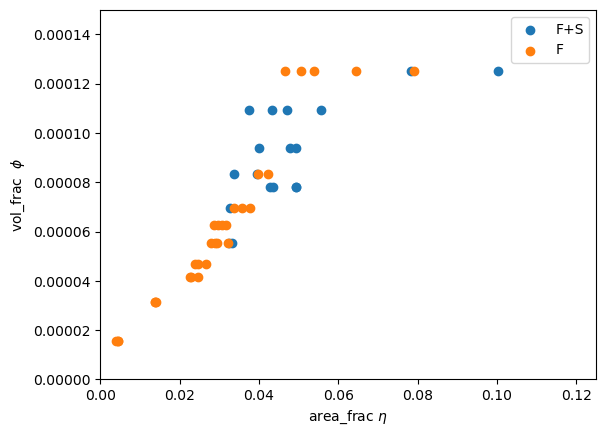

In [131]:
fig,ax=plt.subplots(1)
filtered_df=data_df[data_df['phase']=='c']
ax.scatter(filtered_df['area_frac'],filtered_df['vol_frac'],label='F+S')

filtered_df=data_df[data_df['phase']=='f']
ax.scatter(filtered_df['area_frac'],filtered_df['vol_frac'],label='F')

ax.legend()
ax.set_ylabel('vol_frac  '+r'$\phi$')
ax.set_xlabel('area_frac '+r'$\eta$')
ax.set_xlim(0,1)

fig,ax=plt.subplots(1)
filtered_df=data_df[data_df['phase']=='c']
ax.scatter(filtered_df['area_frac'],filtered_df['vol_frac'],label='F+S')
filtered_df=data_df[data_df['phase']=='f']
ax.scatter(filtered_df['area_frac'],filtered_df['vol_frac'],label='F')
ax.legend()
ax.set_ylabel('vol_frac  '+r'$\phi$')
ax.set_xlabel('area_frac '+r'$\eta$')
ax.set_xlim(0,0.125)
ax.set_ylim(0,0.00015)

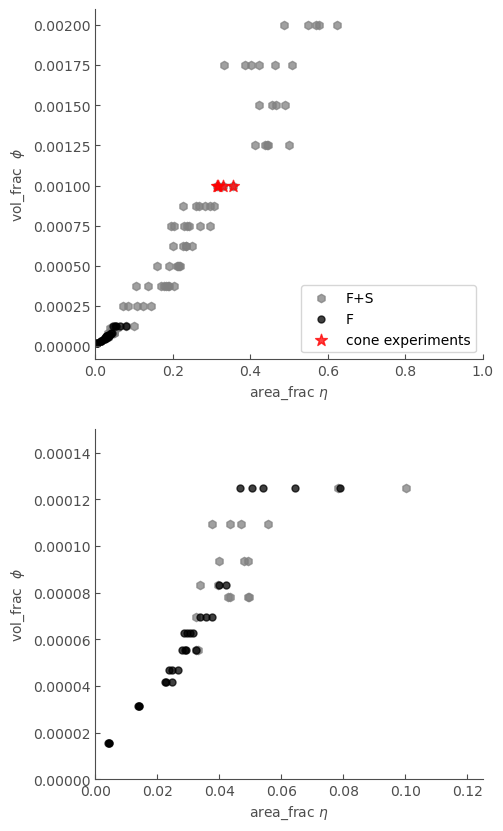

In [339]:
fig,axs=plt.subplots(2,1)
fig.set_size_inches(5,10)
ax=axs[0]
filtered_df=data_df[data_df['phase']=='c']
ax.scatter(filtered_df['area_frac'],filtered_df['vol_frac'],marker='h',label='F+S',color='0.5',alpha=0.75)
filtered_df=data_df[data_df['phase']=='f']
ax.scatter(filtered_df['area_frac'],filtered_df['vol_frac'],s=25,marker='o',label='F',color='0',alpha=0.75)
filtered_df=data_df[data_df['conc_prepared']==0.4]
ax.scatter(filtered_df['area_frac'],filtered_df['vol_frac'],s=80,marker='*',color='red',label='cone experiments',alpha=0.75)
ax.legend()
ax.set_ylabel('vol_frac  '+r'$\phi$')
ax.set_xlabel('area_frac '+r'$\eta$')
ax.set_xlim(0,1)

axis_color='0.3'
ax.tick_params(direction="in",colors=axis_color)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color(axis_color)
ax.spines['left'].set_color(axis_color)
ax.xaxis.label.set_color(axis_color)
ax.yaxis.label.set_color(axis_color)

# im_path=dir_path+'/all grains/orientation/full/grain/'+'122'+'_'+files_df.iloc[122]['file_name'].split('.')[0]
# plt.savefig(im_path+'.svg',bbox_inches='tight', pad_inches=0)    
# plt.savefig(im_path+'.png',bbox_inches='tight', pad_inches=0)    
# # plt.savefig(dir_path+'/all grains/bands/plots/bandwidth_vs_sectorangle.png')
# # plt.savefig(dir_path+'/all grains/bands/plots/bandwidth_vs_sectorangle.svg')
ax=axs[1]
filtered_df=data_df[data_df['phase']=='c']
ax.scatter(filtered_df['area_frac'],filtered_df['vol_frac'],marker='h',label='F+S',color='0.5',alpha=0.75)
filtered_df=data_df[data_df['phase']=='f']
ax.scatter(filtered_df['area_frac'],filtered_df['vol_frac'],s=25,marker='o',label='F',color='0',alpha=0.75)
filtered_df=data_df[data_df['conc_prepared']==0.4]
ax.scatter(filtered_df['area_frac'],filtered_df['vol_frac'],s=80,marker='*',color='red',label='cone experiments',alpha=0.75)
# ax.legend()
ax.set_ylabel('vol_frac  '+r'$\phi$')
ax.set_xlabel('area_frac '+r'$\eta$')
ax.set_xlim(0,0.125)
ax.set_ylim(0,0.00015)

rect = patches.Rectangle((50, 100), 40, 30, linewidth=1, edgecolor='r', facecolor='none')

axis_color='0.3'
ax.tick_params(direction="in",colors=axis_color)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color(axis_color)
ax.spines['left'].set_color(axis_color)
ax.xaxis.label.set_color(axis_color)
ax.yaxis.label.set_color(axis_color)

# im_path=dir_path+'/all grains/orientation/full/grain/'+'122'+'_'+files_df.iloc[122]['file_name'].split('.')[0]
# plt.savefig(im_path+'.svg',bbox_inches='tight', pad_inches=0)    
# plt.savefig(im_path+'.png',bbox_inches='tight', pad_inches=0)    
plt.savefig('area_frac.png',bbox_inches='tight', pad_inches=0)
plt.savefig('area_frac.svg',bbox_inches='tight', pad_inches=0)

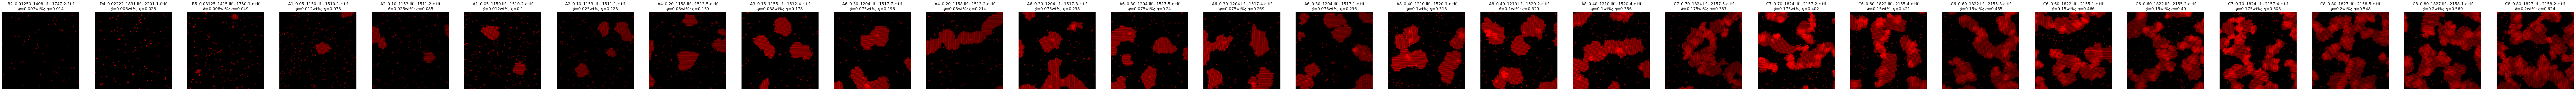

In [338]:
binwidth=0.02
data_df['bin_idx']=np.digitize(data_df['area_frac'],bins=np.arange(0,1+binwidth,binwidth))

im_list=[]
for bin_idx in np.unique(data_df['bin_idx']):
    selected=data_df[data_df['bin_idx']==bin_idx].iloc[[0]]
    im_list+=[selected]
    
fig,axs=plt.subplots(1,len(im_list))
fig.set_size_inches(5*len(im_list),5)
for im_idx in range(len(im_list)):
    selected_df=im_list[im_idx]
    ax=axs[im_idx]    
    im=plt.imread(selected_df['pathname'].values[0])
    ax.imshow(im)    
    ax.set_title(selected_df['filename'].values[0]+
                 '\n'+r'$\phi$='+str(round(selected_df['conc_final'].values[0],3))+'wt%; '+r'$\eta$='+str(round(selected_df['area_frac'].values[0],3)))
    ax.axis('off')
plt.savefig('phase_images.png',bbox_inches='tight', pad_inches=0)
plt.savefig('phase_images.svg',bbox_inches='tight', pad_inches=0)